In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from thalamus_merfish_analysis import ccf_plots as cplot
from thalamus_merfish_analysis import ccf_images as cimg
from thalamus_merfish_analysis import ccf_registration as ccf
from thalamus_merfish_analysis import abc_load as abc
get_ipython().run_line_magic('matplotlib', 'inline') 

# Load brain3 data

In [3]:
# realigned just loads faster version here
obs = abc.get_combined_metadata(realigned=True, version="20230830", drop_unused=False)

In [4]:
realigned=True
ccf_polygons = abc.get_ccf_labels_image(resampled=True, realigned=realigned)

### preprocessing

In [5]:
th_names = abc.get_thalamus_names(level='structure')
th_structure_names = list(set(th_names).difference(['TH-unassigned']))
if realigned:
    ccf_label = 'parcellation_structure_realigned'
    coords = 'section'
else:
    ccf_label = 'parcellation_structure'
    coords = 'reconstructed'

In [6]:
# remove non-neuronal and some other outlier non-thalamus types
obs_neurons = abc.filter_adata_by_class(obs, filter_midbrain=False)
obs_th_neurons = abc.filter_by_thalamus_coords(obs_neurons, realigned=realigned)

In [7]:
# def combine_labels(ccf_index, image, names, combined_name):
#     reverse_index = pd.Series(ccf_index.index, index=ccf_index)
#     ccf_ids = reverse_index.loc[names].values
#     image = np.where(np.any([image==i for i in ccf_ids], axis=0), ccf_ids[0], image)
#     ccf_index[ccf_ids[0]] = combined_name
#     return ccf_index, image

## define eroded regions

In [8]:
obs_neurons_ccf = obs_th_neurons.copy()

In [9]:
section_col = 'z_section'
sections_all = sorted(obs_th_neurons[section_col].unique())
sections_int = np.rint(np.array(sections_all)/0.2).astype(int)
poly_eroded = cimg.sectionwise_label_erosion(ccf_polygons, 10, section_list=sections_int)

In [10]:
coord_names = [f"{x}_{coords}" for x in 'xyz'] # zyx order 
resolutions = np.array([10e-3, 10e-3, 200e-3])
new_ccf_index = 'parcellation_index_eroded'
obs_neurons_ccf = abc.label_masked_cells(obs_neurons_ccf, poly_eroded, coord_names, resolutions, field_name=new_ccf_index)

In [11]:
# add parcellation metadata
ccf_index = abc.get_ccf_index(level='structure')
ccf_label = 'parcellation_structure_eroded'
obs_neurons_ccf[ccf_label] = obs_neurons_ccf[new_ccf_index].map(ccf_index)
obs_neurons_ccf[ccf_label].value_counts()

parcellation_structure_eroded
unassigned       54482
VPM               4060
MD                2471
PO                2163
LP                1705
RT                1696
PF                1332
ZI                1328
LD                1210
PVT                937
VM                 922
AV                 764
MH                 763
VPL                669
VAL                644
RE                 522
LGv                464
LGd                441
PT                 388
AM                 363
LH                 330
MG                 329
SPA                276
VPMpc              254
CM                 211
SMT                201
AD                 178
PIL                115
Eth                 89
SPFm                85
IMD                 81
PoT                 76
SGN                 62
TH-unassigned       49
VPLpc               49
CL                  23
PR                  22
PCN                 18
RH                  15
Xi                  15
IAM                  5
IAD                  4
SPFp

## which regions to plot?

In [95]:
regions_subset = [
    'AD',
    'AV',
    'LD',
    'LGd',
    # VP combine?
    'VPM',
    'VPL',
    'AM',
    'VPMpc',
    'MD',
    'LP',
    'PO',
    'IAD',
    'VAL',
    'VM',
    'RE',
    'CL',
    'PF',
    'CM',
    'PCN',
    'SPA',
    'IMD',
    'PVT',
    # additional
    'MH',
    'LH',
    'RT',
    # 'ZI'
]

In [96]:
regions_100 = obs_neurons_ccf[ccf_label].value_counts().loc[lambda x: x>100].index.difference(['unassigned'])
regions_100.difference(regions_subset)

Index(['LGv', 'MG', 'PIL', 'PT', 'SMT', 'ZI'], dtype='object', name='parcellation_structure_eroded')

In [97]:
# could maybe keep IMD, rest are very small
set(regions_subset) - set(regions_100)

{'CL', 'IAD', 'IMD', 'PCN'}

In [98]:
regions_subset = list(set(regions_subset) & set(regions_100))
len(regions_subset)

21

In [16]:
# unique, counts = np.unique(poly_eroded[:,:,sections_int], return_counts=True)
# areas = pd.Series(counts, index=unique)
# areas.index = areas.index.map(ccf_index)
# areas = areas.loc[areas.index.intersection(th_structure_names)]
# areas.sort_values()

## Cell Type overall counts


In [17]:
th_clusters = obs_neurons_ccf['cluster'].value_counts().loc[lambda x: x>5].index
th_supertypes = obs_neurons_ccf['supertype'].value_counts().loc[lambda x: x>5].index
th_subclasses = obs_neurons_ccf['subclass'].value_counts().loc[lambda x: x>5].index
print("Types with >5 cells")
print(f'{len(th_clusters)=}')
print(f'{len(th_supertypes)=}')
print(f'{len(th_subclasses)=}')

Types with >5 cells
len(th_clusters)=438
len(th_supertypes)=126
len(th_subclasses)=43


In [18]:
obs_neurons_eroded = obs_neurons_ccf.loc[lambda df: df[ccf_label].isin(th_structure_names)]
th_clusters = obs_neurons_eroded['cluster'].value_counts().loc[lambda x: x>5].index
th_supertypes = obs_neurons_eroded['supertype'].value_counts().loc[lambda x: x>5].index
th_subclasses = obs_neurons_eroded['subclass'].value_counts().loc[lambda x: x>5].index
print("Types with >5 cells in the eroded regions")
print(f'{len(th_clusters)=}')
print(f'{len(th_supertypes)=}')
print(f'{len(th_subclasses)=}')

Types with >5 cells in the eroded regions
len(th_clusters)=241
len(th_supertypes)=93
len(th_subclasses)=27


In [107]:
# generate lists of the clusters, supertypes, subclasses, and classes present
# in the thalamus data
th_clusters = obs_neurons_ccf['cluster'].drop_duplicates().tolist()
th_supertypes = obs_neurons_ccf['supertype'].drop_duplicates().tolist()
th_subclasses = obs_neurons_ccf['subclass'].drop_duplicates().tolist()
print(f'{len(th_clusters)=}')
print(f'{len(th_supertypes)=}')
print(f'{len(th_subclasses)=}')

len(th_clusters)=601
len(th_supertypes)=165
len(th_subclasses)=58


# calculate metrics

In [20]:
def get_region_metric(obs_neurons_ccf, ccf_label, function, name, 
                      norm_fcn=None,
                      levels=['cluster','supertype','subclass']):
    th_metrics = (obs_neurons_ccf.loc[lambda df: ~df[ccf_label].isin(['unassigned','TH-unassigned'])]
                        .groupby(ccf_label, observed=True)[levels]
                        .aggregate(function)
                        .rename(columns=lambda x: "_".join([name, x])))
    if norm_fcn is not None:
        th_metrics = th_metrics / obs_neurons_ccf[levels].apply(norm_fcn).values[None,:]
    return th_metrics


In [21]:

count = lambda x: len(x.unique())
norm_count = lambda x: len(x.unique())/len(x)
count_gt5 = lambda x: len(x.value_counts().loc[lambda c: c>5])
inverse_simpsons = lambda x: 1/np.sum((x.value_counts().loc[lambda c: c>0]/len(x))**2)

th_metrics = pd.concat([
    get_region_metric(obs_neurons_ccf, ccf_label, count, "n"),
    get_region_metric(obs_neurons_ccf, ccf_label, count, "frac", norm_fcn=count),
    get_region_metric(obs_neurons_ccf, ccf_label, norm_count, "norm_count"),
    get_region_metric(obs_neurons_ccf, ccf_label, count_gt5, "count_gt5"),
    get_region_metric(obs_neurons_ccf, ccf_label, inverse_simpsons, "inverse_simpsons"),
], axis=1)
th_metrics['count'] = obs_neurons_ccf[ccf_label].value_counts()
# th_metrics = th_metrics.drop(index='unassigned')

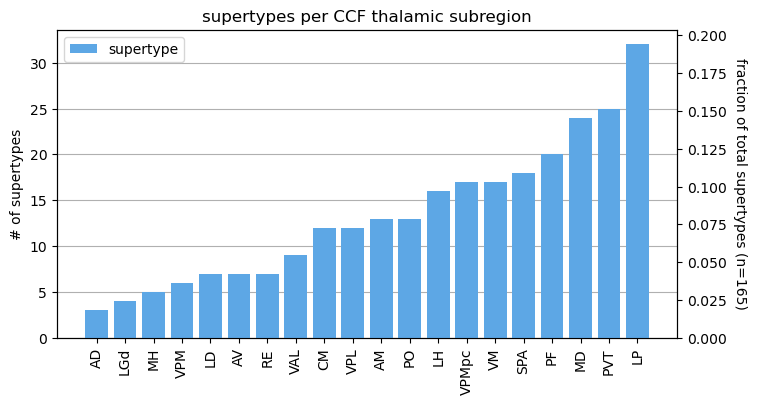

In [22]:

th_metrics_sorted = th_metrics.loc[regions_subset].sort_values(by='frac_supertype', ascending=True)

# th_metrics_sorted

fig, ax1 = plt.subplots(figsize=(8,4))

# Plot the absolute values on the left y-axis
ax1.scatter(th_metrics_sorted.index, th_metrics_sorted['n_supertype'], color='#5DA7E5', alpha=0)
ax1.set_ylabel('# of supertypes', color='k')
ax1.tick_params(axis='y', labelcolor='k')
ax1.set_xticks(th_metrics_sorted.index)
ax1.set_xticklabels(th_metrics_sorted.index, rotation=90)
ax1.set_ylim(0, th_metrics_sorted['n_supertype'].max()*1.05)
plt.grid(visible=True, axis='y')

# Create a secondary y-axis on the right
ax2 = ax1.twinx()

# Plot the fraction values on the right y-axis
ax2.bar(th_metrics_sorted.index, th_metrics_sorted['frac_supertype'], color='#5DA7E5', label='supertype')
ax2.set_ylabel('fraction of total supertypes (n='+str(len(th_supertypes))+')', color='k', rotation=270, labelpad=15)
ax2.set_ylim(0, th_metrics_sorted['frac_supertype'].max()*1.05)
ax2.tick_params(axis='y', labelcolor='k')
ax2.legend()

# plt.xticks(rotation=90)
plt.xlabel('CCF thalamic subregions')
plt.title('supertypes per CCF thalamic subregion')

plt.show()

In [23]:
def plot_metrics_multiple_levels(th_metrics, metric, levels=['cluster','subclass']):
    fig, ax1 = plt.subplots(figsize=(8,4))

    th_metrics_sorted = th_metrics.sort_values(by="_".join([metric, levels[0]]), ascending=True)
    for level in levels[::-1]:
        ax1.scatter(th_metrics_sorted.index, th_metrics_sorted["_".join([metric, level])], 
                     label=level, zorder=2) 
    ax1.set_xticks(th_metrics_sorted.index)
    ax1.set_xticklabels(th_metrics_sorted.index, rotation=90)
    ax1.set_ylabel(metric)
    ax1.legend()
    plt.grid(visible=True, axis='both', zorder=0, color='whitesmoke')


Text(0, 0.5, 'cell type count')

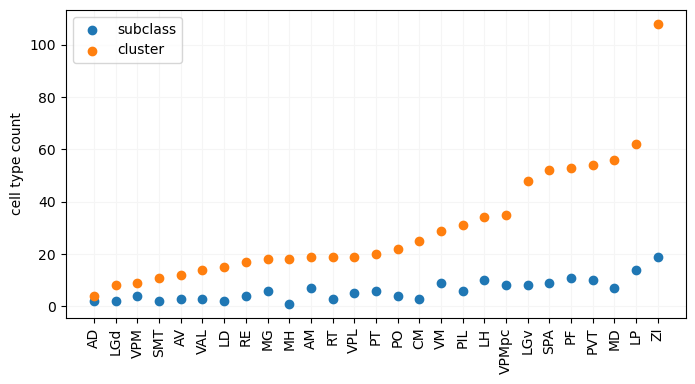

In [24]:
plot_metrics_multiple_levels(th_metrics.loc[regions_100], 'n')
plt.ylabel("cell type count")

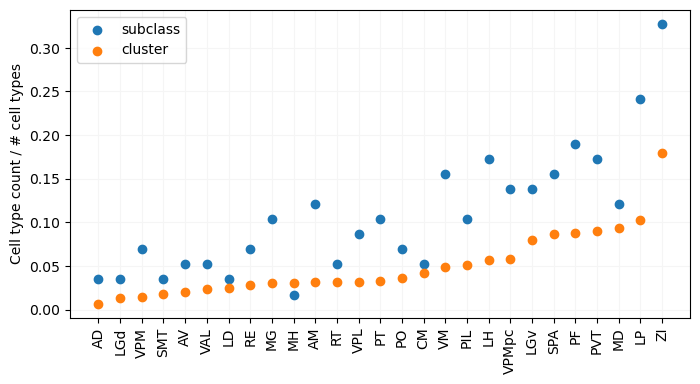

In [25]:
plot_metrics_multiple_levels(th_metrics.loc[regions_100], 'frac')
plt.ylabel('Cell type count / # cell types');

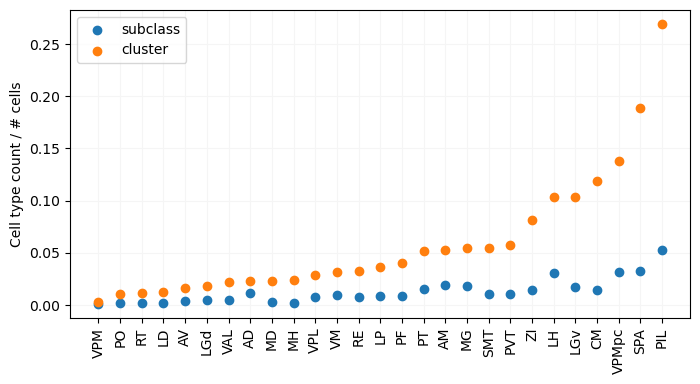

In [26]:
plot_metrics_multiple_levels(th_metrics.loc[regions_100], 'norm_count')
plt.ylabel('Cell type count / # cells');

Text(0, 0.5, 'cell type count (outliers removed)')

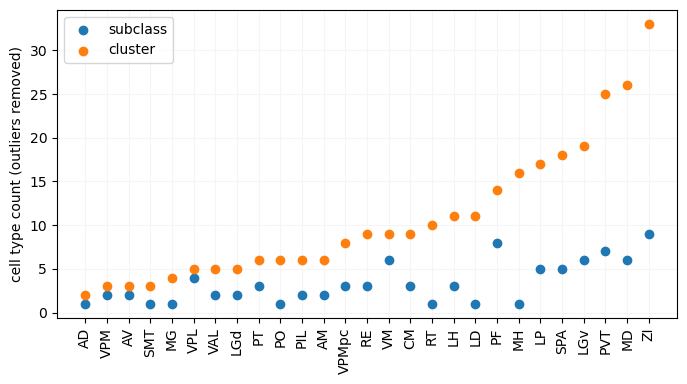

In [27]:
plot_metrics_multiple_levels(th_metrics.loc[regions_100], 'count_gt5')
plt.ylabel("cell type count (outliers removed)")

<Axes: xlabel='count', ylabel='count_gt5_cluster'>

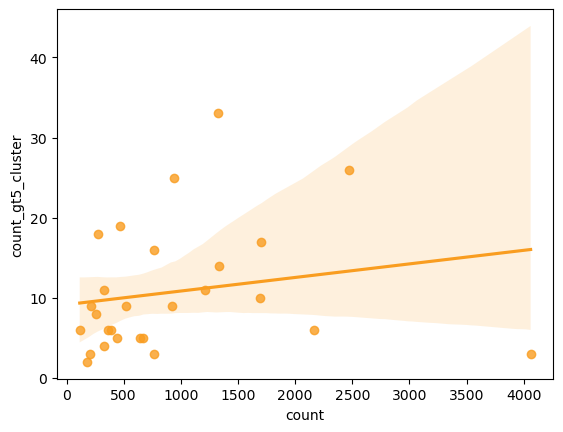

In [28]:
# effect of region size is weak but probably still present...
import seaborn as sns
sns.regplot(th_metrics.loc[regions_100], x='count', y='count_gt5_cluster', color='#F99D20', label='cluster') 

### CCF colored by value

In [29]:
imdata = abc.get_ccf_labels_image(resampled=True).astype(int)
# x, y, z orientation
imdata.shape

(1100, 1100, 76)

In [30]:
{i: len(set(ccf_index[np.unique(imdata[:,:,i])]) & set(regions_100)) for i in sections_int}


{25: 2,
 27: 3,
 28: 6,
 29: 5,
 31: 11,
 32: 13,
 33: 17,
 34: 18,
 35: 18,
 36: 18,
 38: 16,
 39: 16,
 40: 13,
 41: 8}

In [31]:
{i: len(set(ccf_index[np.unique(imdata[:,:,i])]) & set(regions_subset)) for i in sections_int}


{25: 0,
 27: 1,
 28: 2,
 29: 2,
 31: 8,
 32: 10,
 33: 14,
 34: 14,
 35: 14,
 36: 14,
 38: 13,
 39: 13,
 40: 10,
 41: 6}

In [32]:
sections = [6.8] 

6.8


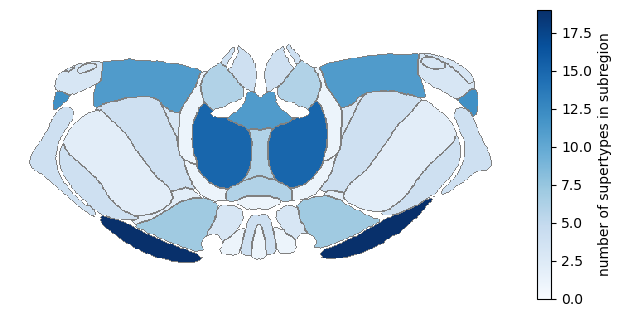

In [33]:
cplot.plot_metrics_ccf_raster(imdata, th_metrics['count_gt5_supertype'], sections, ccf_index,
                            cmap='Blues', cb_label='number of supertypes in subregion')

6.8


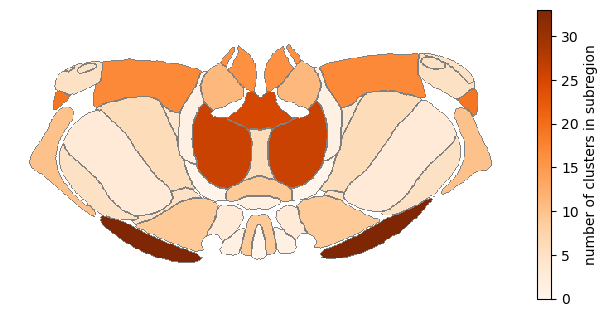

In [34]:
cplot.plot_metrics_ccf_raster(imdata, th_metrics['count_gt5_cluster'], sections, ccf_index,
                       cmap='Oranges', cb_label='number of clusters in subregion')

## Cell Type Diversity

### Shannon Diversity Index

In [35]:
# Shannon diversity index, normalized to (0,1)
# 1 = high diversity (clusters found in equal proportions)
# 0 = low diversity (some clusters found in higher proportions in subregion)

def calc_shannon_index(obs_col):
    # calculate proportion of each category
    cateogory_counts = obs_col.value_counts()
    cateogory_counts = cateogory_counts[cateogory_counts>0] # cleanup zeros so log() doesn't throw warnings
    p = cateogory_counts / cateogory_counts.sum()
    
    # calculate shannon diversity index
    shannon_ind = (-1)*((p * np.log2(p)).sum())
    
    # normalized separately
    # normalize by log2 of number of categories to limit index to range (0, 1)
    # shannon_norm = shannon_ind / np.log2(n_total_categories)
    return shannon_ind

In [36]:
th_metrics = th_metrics.join(
    get_region_metric(obs_neurons_ccf, ccf_label, calc_shannon_index, "shannon_index", 
                      norm_fcn=lambda x: np.log2(len(x.unique())))
)

Text(0, 0.5, 'Shannon index')

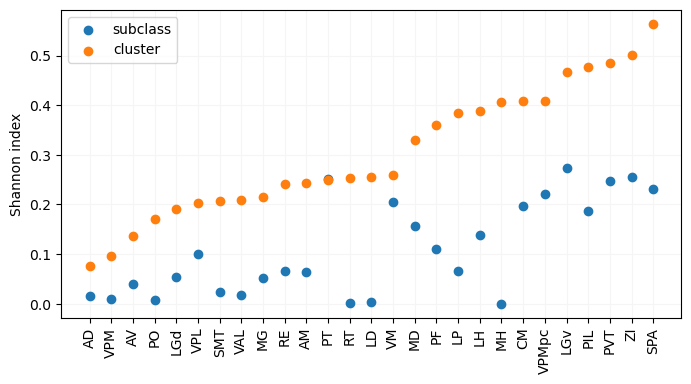

In [37]:
plot_metrics_multiple_levels(th_metrics.loc[regions_100], 'shannon_index')
plt.ylabel("Shannon index")

6.8


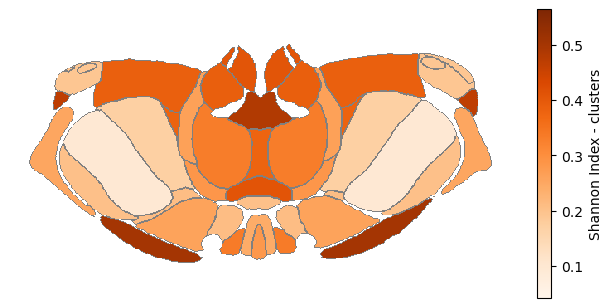

In [38]:

label = 'Shannon Index - clusters'
cplot.plot_metrics_ccf_raster(imdata, th_metrics['shannon_index_cluster'], sections, ccf_index,
                            cmap='Oranges', cb_label=label)

6.8


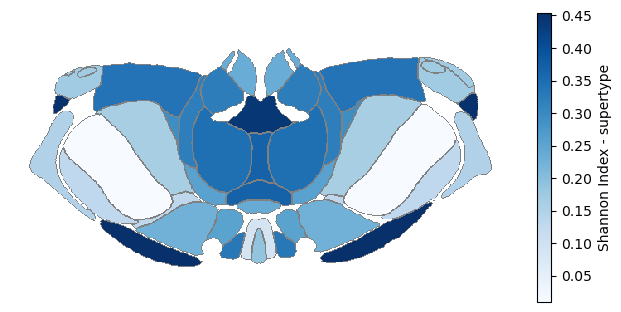

In [39]:

label = 'Shannon Index - supertype'
cplot.plot_metrics_ccf_raster(imdata, th_metrics['shannon_index_supertype'], sections, ccf_index,
                            cmap='Blues', cb_label=label)

6.8


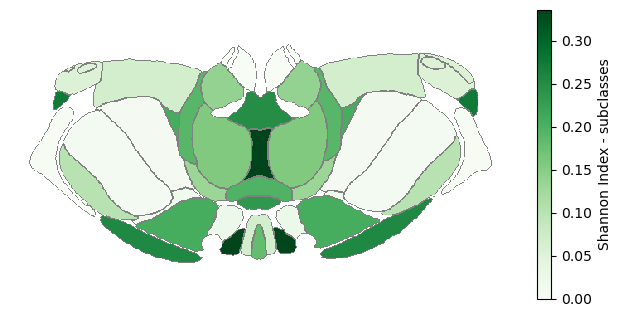

In [40]:

label = 'Shannon Index - subclasses'
cplot.plot_metrics_ccf_raster(imdata, th_metrics['shannon_index_subclass'], sections, ccf_index,
                            cmap='Greens', cb_label=label)

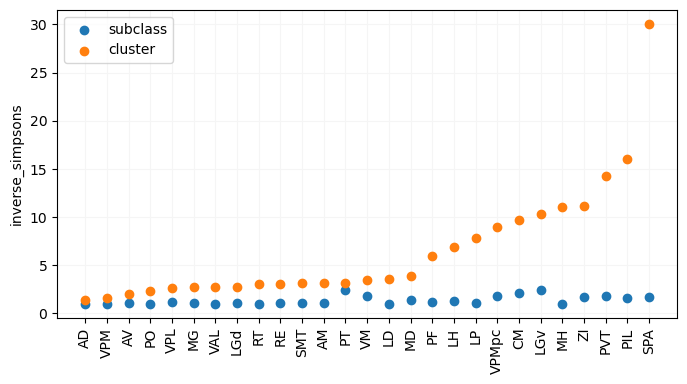

In [41]:
plot_metrics_multiple_levels(th_metrics.loc[regions_100], 'inverse_simpsons')
# plt.ylabel("cell type count (outliers removed)")

In [59]:
sections = [7.2]

7.2


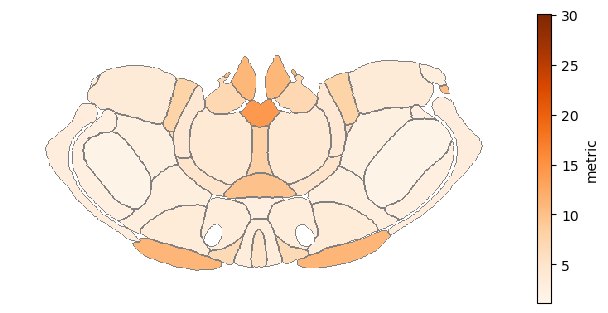

In [60]:
cplot.plot_metrics_ccf_raster(imdata, th_metrics['inverse_simpsons_cluster'], sections, ccf_index,
                       cmap='Oranges')

6.8


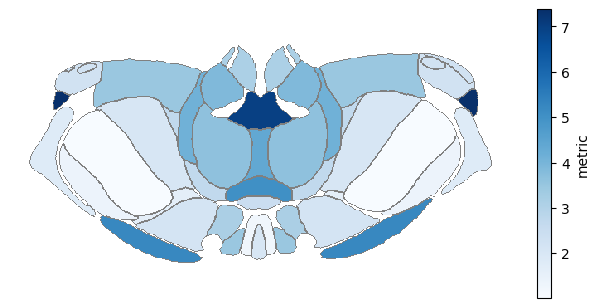

In [43]:
cplot.plot_metrics_ccf_raster(imdata, th_metrics['inverse_simpsons_supertype'], sections, ccf_index,
                       cmap='Blues')

6.8


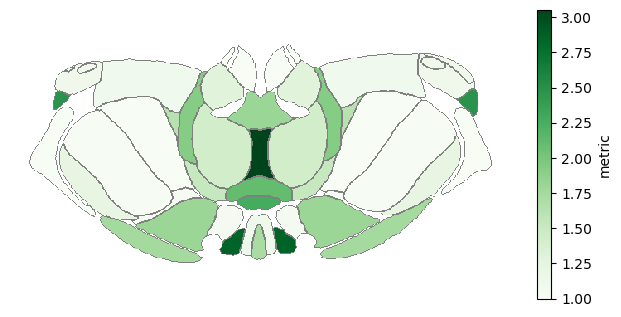

In [44]:
cplot.plot_metrics_ccf_raster(imdata, th_metrics['inverse_simpsons_subclass'], sections, ccf_index,
                       cmap='Greens')

## local index

In [65]:
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=20, n_jobs=-1)
neigh_coords = [x+'_ccf' for x in 'xyz']
X = obs_neurons_ccf[neigh_coords].values
neigh.fit(X)

NearestNeighbors(n_jobs=-1, n_neighbors=20)

In [75]:
from multiprocessing import Pool
# def local_index(obs_neurons_ccf, function, name, ccf_label, n_neighbors=15, levels=['cluster']):
function = inverse_simpsons
name='isi'
n_neighbors=15
levels=['cluster', 'subclass']

neighbors = neigh.kneighbors(X, n_neighbors=n_neighbors, return_distance=False)

def fcn(i): 
    return obs_neurons_ccf.iloc[neighbors[i]][levels].aggregate(function)

with Pool() as p:
    out = p.map(fcn, range(len(obs_neurons_ccf)))

In [84]:
cellwise_metrics = pd.DataFrame.from_records(out, index=obs_neurons_ccf.index).rename(columns=lambda x: "_".join(['local', name, x]))
metrics = cellwise_metrics.join(obs_neurons_ccf[ccf_label]).groupby(ccf_label, observed=True).median()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


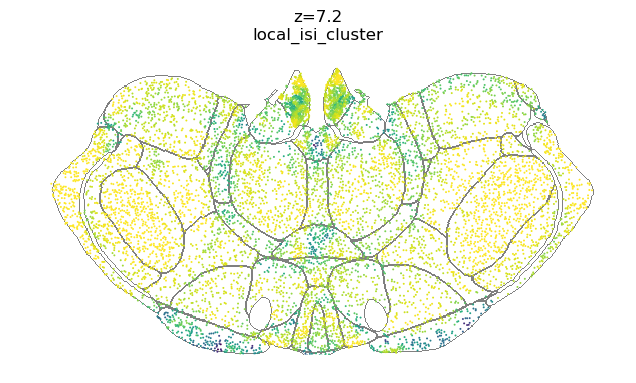

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


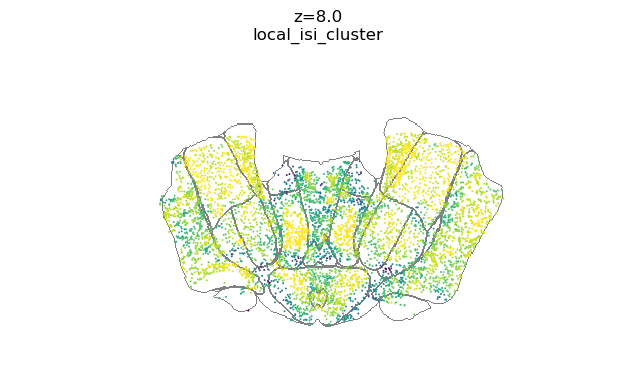

In [94]:
obs = obs_neurons_ccf.join(cellwise_metrics)
kwargs = dict(
    section_col=section_col,
    x_col = 'x_'+coords,
    y_col = 'y_'+coords,
    s=2, 
    shape_palette='dark_outline',
    # boundary_img=ccf_boundaries
)
figs = cplot.plot_ccf_overlay(obs, ccf_polygons, point_hue='local_isi_cluster', point_palette='viridis_r', 
                       categorical=False, legend=False, sections=[7.2, 8.0], **kwargs)
for i, fig in enumerate(figs):
    fig.savefig(f"/results/local_isi_sec{i}.pdf")

In [47]:
# local index - about 2 min to run!

# n_neighbors = 15
# neighbors = neigh.kneighbors(X, n_neighbors=n_neighbors, return_distance=False)
# neighbors_series = pd.Series(neighbors.tolist(), index=obs_neurons_ccf.index)

# def local_metric(label_series, neighbors_series, function):
#     results = np.array([
#         function(
#     # doesn't include neighbors across boundaries...
#             # label_series.reindex(obs_neurons_ccf.index[ind]).dropna()
#             # label_series[label_series.index.intersection(obs_neurons_ccf.index[ind])]
#             obs_neurons_ccf[label_series.name].iloc[ind]
#             )
#         for ind in neighbors_series[label_series.index]
#         ])
#     return np.median(results)

# lisi = lambda x: local_metric(x, neighbors_series, inverse_simpsons)
# th_lisi = get_region_metric(obs_neurons_ccf, ccf_label, lisi, "lisi", levels=['cluster','supertype','subclass'])

7.2


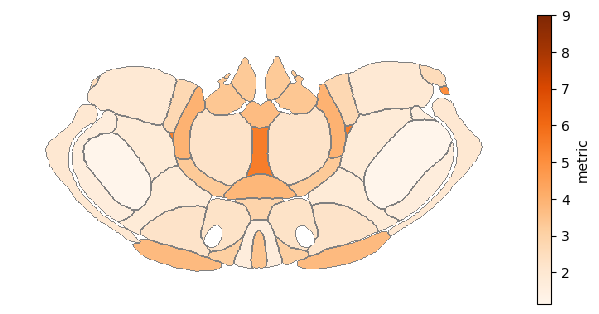

In [58]:
cplot.plot_metrics_ccf_raster(imdata, metrics["local_isi_cluster"], sections, ccf_index,
                       cmap='Oranges')

6.8


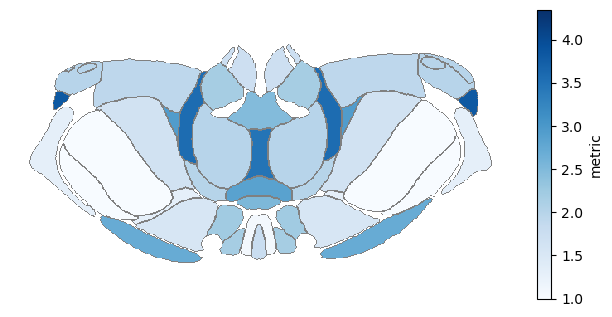

In [50]:
cplot.plot_metrics_ccf_raster(imdata, metrics["local_isi_supertype"], sections, ccf_index,
                       cmap='Blues')

6.8


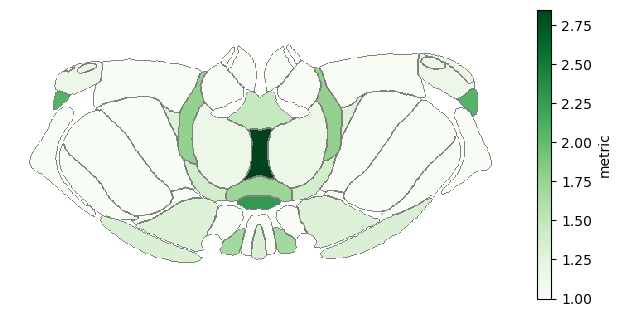

In [51]:
cplot.plot_metrics_ccf_raster(imdata, metrics["local_isi_subclass"], sections, ccf_index,
                       cmap='Greens')


## Proportions as stacked bar graphs

In [100]:
# for each subregion, count the proportion of cells in each cluster/supertype/subclass
regions = list(regions_subset)
ccf_cluster_counts = pd.DataFrame(0.0, index=regions, columns=th_clusters)
ccf_supertype_counts = pd.DataFrame(0.0, index=regions, columns=th_supertypes)
ccf_subclass_counts = pd.DataFrame(0.0, index=regions, columns=th_subclasses)
min_count = 5
for subregion, df in obs_neurons_ccf.groupby(ccf_label, observed=True):
    if subregion in regions_100:
        # clusters
        cluster_counts = df['cluster'].value_counts().loc[lambda x: x>min_count]
        ccf_cluster_counts.loc[subregion, 
                            cluster_counts.index] = cluster_counts.values / len(df)
        ccf_cluster_counts.loc[subregion, 'other'] = 1-ccf_cluster_counts.loc[subregion].sum()

        # supertypes
        supertype_counts = df['supertype'].value_counts().loc[lambda x: x>min_count]
        ccf_supertype_counts.loc[subregion, 
                                supertype_counts.index] = supertype_counts.values / len(df)
        ccf_supertype_counts.loc[subregion, 'other'] = 1-ccf_supertype_counts.loc[subregion].sum()

        # subclasses
        subclass_counts = df['subclass'].value_counts().loc[lambda x: x>min_count]
        ccf_subclass_counts.loc[subregion, 
                                subclass_counts.index] = subclass_counts.values / len(df)
        ccf_subclass_counts.loc[subregion, 'other'] = 1-ccf_subclass_counts.loc[subregion].sum()

#### TODO: Implement barchart w/ plotly

which will enable hovering over the bars to display the subclass/supertype/cluster to which it belongs

In [108]:
# display as a stacked bar graph
from colorcet import glasbey_light, glasbey

def plot_stacked_barplot(df, taxonomy_level, legend=True, palette='taxonomy'):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,5))
    if palette is None:
        colors = sns.color_palette(glasbey, n_colors=len(df.columns), desat=None)
        palette = dict(zip(df.columns, colors))
    elif palette=='taxonomy':
        palette = abc.get_taxonomy_palette(taxonomy_level)
    palette['other'] = 'grey'
    df.plot(kind='bar', stacked=True, ax=axes, legend=legend, color=palette)
    if legend:
        axes.legend(loc='upper left', bbox_to_anchor=(0.05, -0.3), ncol=4)
    axes.set_xticklabels(df.index, rotation=90)
    axes.set_xlabel('CCF subregion')
    # axes.set_yticks([])
    axes.set_ylabel('proportion of cells in unique '+taxonomy_level)

    fig.subplots_adjust(hspace=0.1)
    
    # add text
    for i, subregion in enumerate(df.index):
        n_nonzero = (df.loc[subregion, df.columns!='other']>0).sum()
        axes.text(i, 1.01, n_nonzero, horizontalalignment='center')
    plt.show()

#### Subclasses

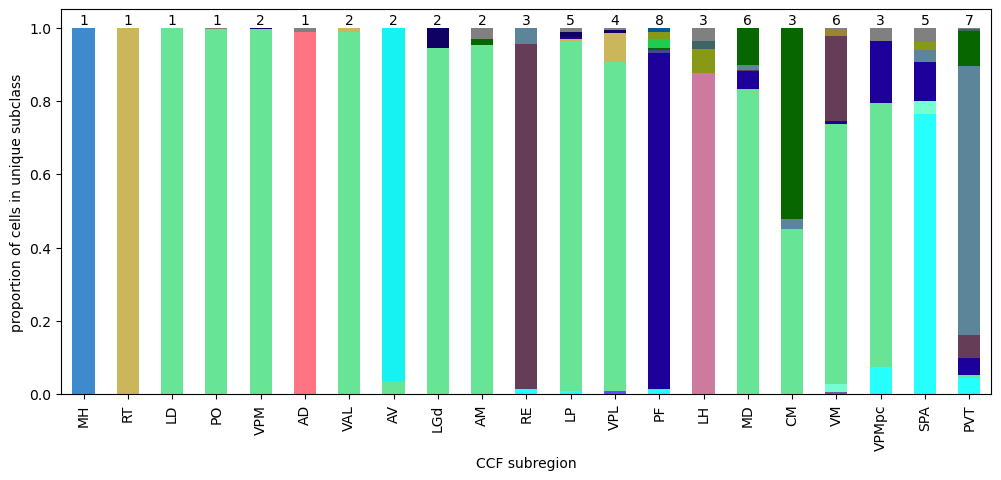

In [102]:
# First sort by the Shannon Diversity Index from th_metrics
th_metrics_sorted_by_sdi = th_metrics.loc[regions].sort_values(by='shannon_index_subclass', ascending=True)

# Use sorted list of subregions to plot in order from least diverse to most diverse
plot_stacked_barplot(ccf_subclass_counts.loc[list(th_metrics_sorted_by_sdi.index)], 
                     'subclass', legend=False)

#### Supertypes

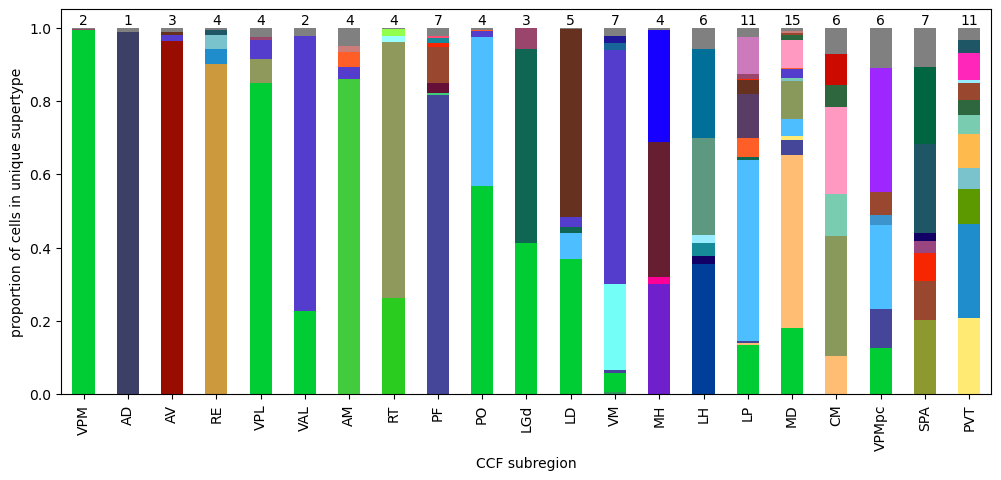

In [105]:
# First sort by the Shannon Diversity Index from th_metrics
th_metrics_sorted_by_sdi = th_metrics.loc[regions].sort_values(by='shannon_index_supertype', ascending=True)

# Use sorted list of subregions to plot in order from least diverse to most diverse
plot_stacked_barplot(ccf_supertype_counts.loc[th_metrics_sorted_by_sdi.index], 
                     'supertype', legend=False)

#### Clusters

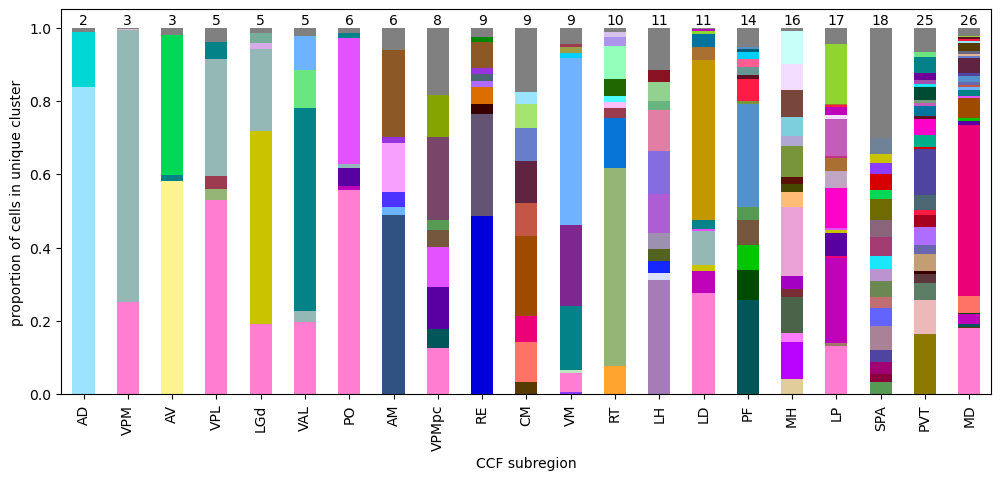

In [109]:
# TODO: why not matched palette?
th_metrics_sorted_by_sdi = th_metrics.loc[regions].sort_values(
    by='count_gt5_cluster', ascending=True)

# Use sorted list of subregions to plot in order from least diverse to most diverse
plot_stacked_barplot(ccf_cluster_counts.loc[th_metrics_sorted_by_sdi.index], 
                     'cluster', palette=None, legend=False)

# Per Cluster/Supertype/Subclass Metrics (neurons only)

## TODO: Dispersion of clusters/supertypes across nuclei

i.e. grab a cluster that dominates in one nucleus (e.g. 1133 in MD) and ask how dispersed it is across the whole thalamus. Ideally, a linear metric, such that you could ask what the dispersion is for all clusters to see which ones seem to be more compact and which are more shared

I *think* this is going to have to be done on hemispheres, rather than the whole brain. Most existing tools I'm finding are not able to account for symmetries.

Likely going to borrow from some of ArcGIS's standard toolboxes
- https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-statistics/h-how-standard-distance-spatial-statistic-works.htm

Or other satellite imagery methods:
- https://www.tandfonline.com/doi/full/10.1080/17538947.2018.1474957